# Spaceship Titanic
### By Ahsan Shakoor

**1. Grading criteria**

Grade 3 (Pass):
- Code runs without errors when "Run All" is executed.
- Test predictions are generated, saved, and submitted to the competition.
- Includes basic data analysis, preprocessing, model building, and predictions.
- Leaderboard score is > 0.5 (better than random guessing).

Grade 4 (Good):
- Meets all criteria for Grade 3.
- Includes clear and meaningful visualizations.
- Leaderboard score is > 0.6.

Grade 5 (Excellent):
- Meets all criteria for Grade 4.
- Provides deeper insights with good visualizations and analysis. You can write a short paragraph to explain your findings.
- Leaderboard score is > 0.7.

NOTE: To achieve a grade, **all criteria must be met**; for example, a score > 0.7 alone won’t earn a 5 without strong visualizations and insightful analysis.

**2. Deadline: Thursday, 26.12.2024**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import optuna


In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

print(f'Train data shape: {train.shape}')
print(f'Test data shape: {test.shape}')

Train data shape: (8693, 14)
Test data shape: (4277, 13)


In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


train.columns

In [5]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [6]:
test.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

<Axes: ylabel='count'>

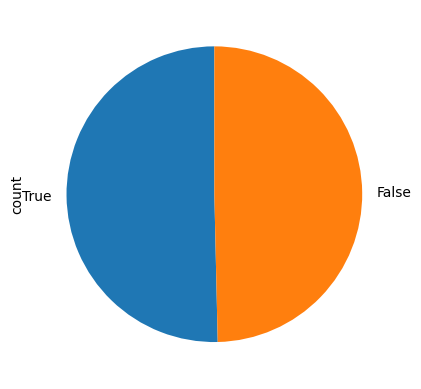

In [7]:
TARGET = 'Transported'
train[TARGET].value_counts().plot(kind='pie', startangle=90)

In [8]:
cat_cols = train.select_dtypes('object').columns
ignore_cols = ['PassengerId', 'Name']
for col in cat_cols:
    if col in ignore_cols: continue
    print(col, train[col].unique())
print('')
for col in cat_cols:
    if col in ignore_cols: continue
    print(col, test[col].unique())

HomePlanet ['Europa' 'Earth' 'Mars' nan]
CryoSleep [False True nan]
Cabin ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP [False True nan]

HomePlanet ['Earth' 'Europa' 'Mars' nan]
CryoSleep [True False nan]
Cabin ['G/3/S' 'F/4/S' 'C/0/S' ... 'D/296/P' 'D/297/P' 'G/1498/S']
Destination ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' nan]
VIP [False nan True]


## Examples of data transformation

In [9]:
# Split the 'Cabin' column into 3 separate columns
train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [10]:
# Create a new column 'Travel_by_group'
train['GroupId'] = train['PassengerId'].str[:4]
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,GroupId
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,0004


In [11]:
train['Travel_by_group'] = (train.groupby('GroupId')['GroupId'].transform('count') > 1).astype('bool')

In [12]:
train.sample()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,GroupId,Travel_by_group
262,0288_01,Earth,False,F/55/S,55 Cancri e,19.0,False,0.0,0.0,0.0,0.0,828.0,Gory Delez,False,F,55,S,0288,False


In [13]:
train[['Firstname', 'Lastname']] = train['Name'].str.split(' ', expand=True)
train.sample(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Deck,Num,Side,GroupId,Travel_by_group,Firstname,Lastname
1578,1670_02,Earth,True,G/269/P,TRAPPIST-1e,44.0,False,0.0,0.0,0.0,...,0.0,Jordy Sancasey,False,G,269,P,1670,True,Jordy,Sancasey
7305,7815_01,Earth,False,F/1496/S,PSO J318.5-22,27.0,False,0.0,605.0,0.0,...,0.0,Jaye Daviddley,True,F,1496,S,7815,False,Jaye,Daviddley


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      8693 non-null   object 
 1   HomePlanet       8492 non-null   object 
 2   CryoSleep        8476 non-null   object 
 3   Cabin            8494 non-null   object 
 4   Destination      8511 non-null   object 
 5   Age              8514 non-null   float64
 6   VIP              8490 non-null   object 
 7   RoomService      8512 non-null   float64
 8   FoodCourt        8510 non-null   float64
 9   ShoppingMall     8485 non-null   float64
 10  Spa              8510 non-null   float64
 11  VRDeck           8505 non-null   float64
 12  Name             8493 non-null   object 
 13  Transported      8693 non-null   bool   
 14  Deck             8494 non-null   object 
 15  Num              8494 non-null   object 
 16  Side             8494 non-null   object 
 17  GroupId       

### --- Feature Engineering ---


In [15]:
train.isna().sum()

PassengerId          0
HomePlanet         201
CryoSleep          217
Cabin              199
Destination        182
Age                179
VIP                203
RoomService        181
FoodCourt          183
ShoppingMall       208
Spa                183
VRDeck             188
Name               200
Transported          0
Deck               199
Num                199
Side               199
GroupId              0
Travel_by_group      0
Firstname          200
Lastname           200
dtype: int64

In [16]:
# print(train.shape)
# train.dropna(inplace=True)
# train.shape

In [17]:
train.shape

(8693, 21)

In [18]:
def preprocess_data(df):
    # Derive 'GroupId' from 'PassengerId'
    df['GroupId'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    
    # Derive 'Deck' and 'Side' from 'Cabin'
    df['Deck'] = df['Cabin'].fillna('Unknown').apply(lambda x: x.split('/')[0] if '/' in x else 'Unknown')
    df['Side'] = df['Cabin'].fillna('Unknown').apply(lambda x: x.split('/')[-1] if '/' in x else 'Unknown')
    
    # Handle missing values and preprocess 'CryoSleep' and 'VIP'
    df['CryoSleep'] = df['CryoSleep'].map({'True': 1, 'False': 0}).fillna(-1).astype(int)
    df['VIP'] = df['VIP'].map({'True': 1, 'False': 0}).fillna(0).astype(int)
    
    # Fill other missing values
    df['RoomService'] = df['RoomService'].fillna(0)
    df['FoodCourt'] = df['FoodCourt'].fillna(0)
    df['ShoppingMall'] = df['ShoppingMall'].fillna(0)
    df['Spa'] = df['Spa'].fillna(0)
    df['VRDeck'] = df['VRDeck'].fillna(0)
    df['Age'] = df['Age'].fillna(0)
    
    # Create additional features
    df['TotalExpenditure'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df['ExpenditureFlag'] = (df['TotalExpenditure'] > 0).astype(int)
    df['FamilySize'] = df['GroupId'].map(df['GroupId'].value_counts())
    
    # Label encode categorical columns
    categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side']
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].fillna('Unknown'))
        label_encoders[col] = le
    
    return df

# Preprocess train and test datasets
train = preprocess_data(train)
test = preprocess_data(test)




/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

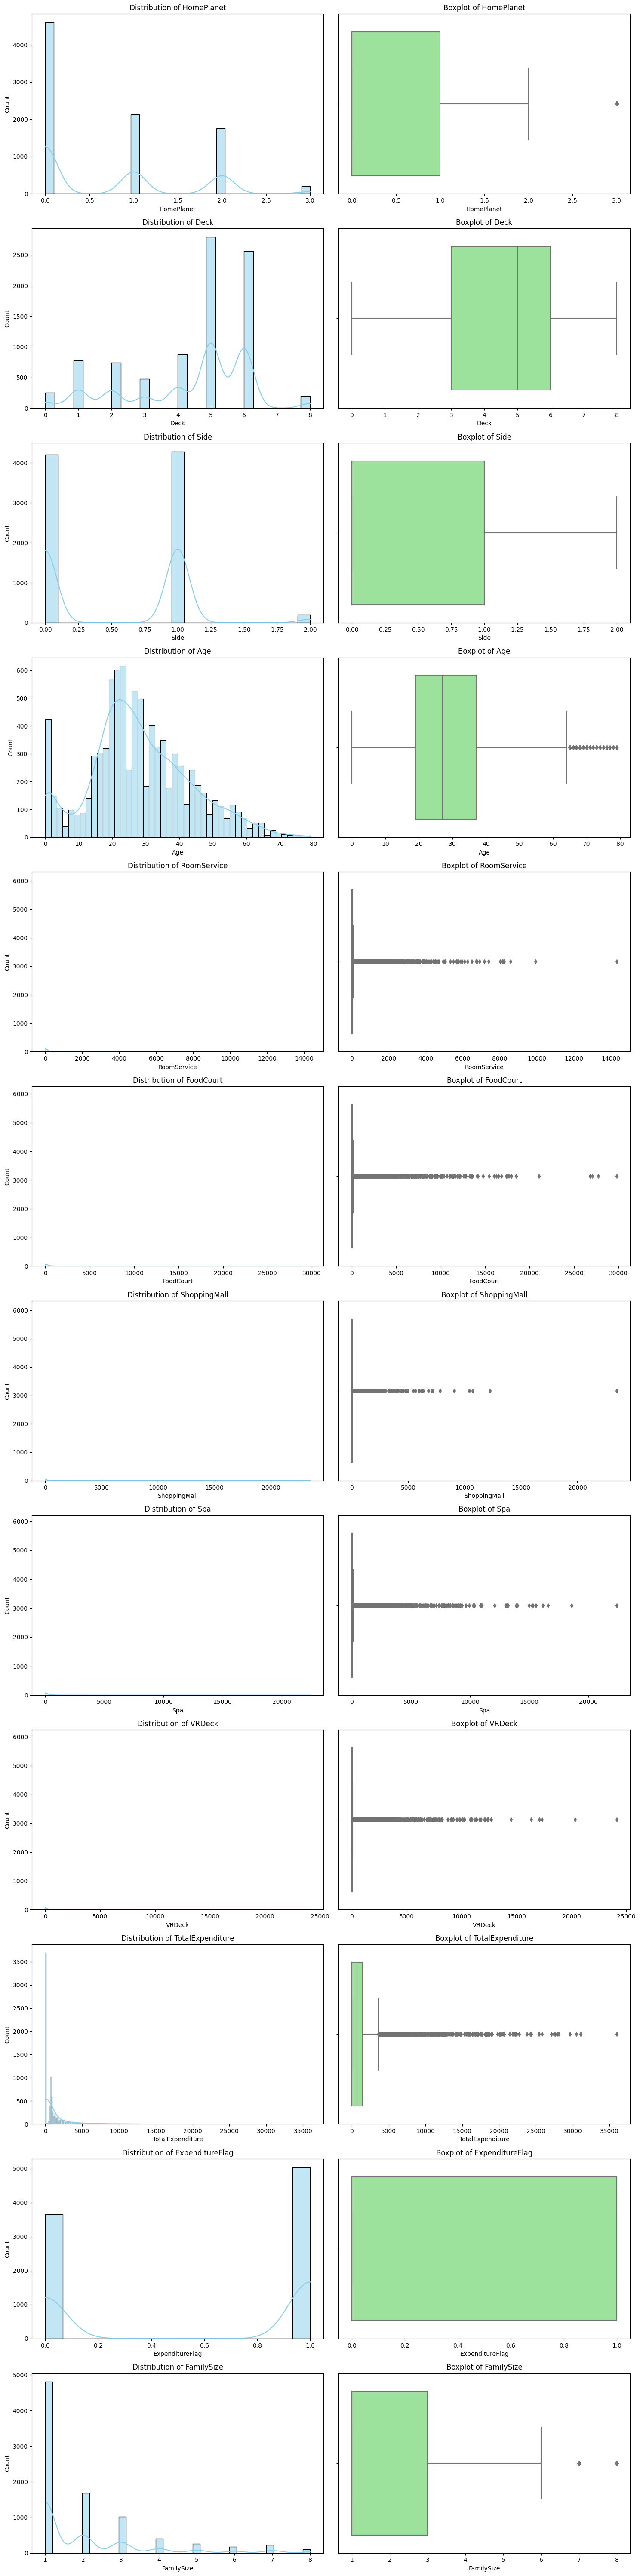

In [19]:


# Function to plot distributions and relationships with the target
def plot_feature_distributions(df, features, target):
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 2, figsize=(15, 5 * n_features))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        # Numerical features
        if df[feature].dtype in ['int64', 'float64']:
            sns.histplot(df[feature], kde=True, ax=axes[2 * i], color="skyblue")
            axes[2 * i].set_title(f"Distribution of {feature}")
            
            sns.boxplot(x=df[feature], ax=axes[2 * i + 1], color="lightgreen")
            axes[2 * i + 1].set_title(f"Boxplot of {feature}")
        # Categorical features
        else:
            sns.countplot(x=df[feature], ax=axes[2 * i], palette="viridis")
            axes[2 * i].set_title(f"Countplot of {feature}")
            
            sns.barplot(x=df[feature], y=df[target], ax=axes[2 * i + 1], palette="muted")
            axes[2 * i + 1].set_title(f"{feature} vs {target}")
    
    plt.tight_layout()
    plt.show()

# Selected features and target column
selected_features = [
    'HomePlanet', 'Deck', 'Side', 'Age',
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
    'TotalExpenditure', 'ExpenditureFlag', 'FamilySize'
]
target_column = 'Transported'

# Generate the plots
plot_feature_distributions(train, selected_features, target_column)


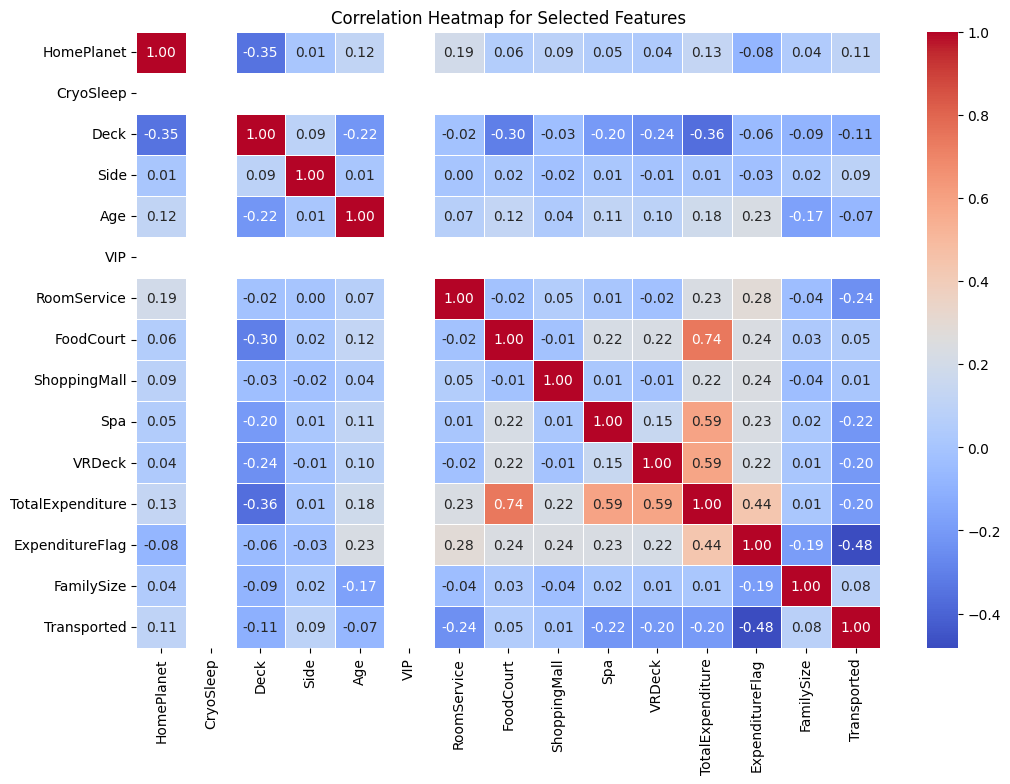

In [20]:
# Features and target
selected_features = ['HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Age', 'VIP', 
                     'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                     'TotalExpenditure', 'ExpenditureFlag', 'FamilySize','Transported']
X = train[selected_features]
# Ensure the selected features and dataset are available
correlation_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap for Selected Features")
plt.show()


### Correlation Analysis

The correlation matrix provides insights into the relationships between the features and the target variable, `Transported`. Here are the key observations:

1. **Focus on `Transported`**:
   - `ExpenditureFlag` (-0.4816): Strong negative correlation with the target, indicating that passengers with higher expenditures were less likely to be transported.
   - `RoomService` (-0.2411), `Spa` (-0.2185), `VRDeck` (-0.2049), and `TotalExpenditure` (-0.1995): All show moderate negative correlations, highlighting the inverse relationship between high spending and being transported.
   - `HomePlanet` (0.1077): Shows a weak positive correlation, suggesting a small association between the home planet and transportation.
   - `Deck` (-0.1099): Weak negative correlation, indicating minimal influence of deck placement on transportation.

2. **Irrelevant Features**:
   - `CryoSleep` and `VIP`: These features had missing values or no meaningful correlation with the target and were excluded from the final model to improve efficiency.

3. **Other Notable Correlations**:
   - `TotalExpenditure` and `ExpenditureFlag`: Strongly positively correlated (0.4376), as expected since `ExpenditureFlag` directly depends on whether there was any expenditure.
   - `FoodCourt` and `TotalExpenditure`: Highly correlated (0.7426), showing that spending in one service strongly contributes to overall expenditure.
   - `FamilySize`: Weakly correlated with `Transported` (0.0826), indicating a minimal effect on the target.

---


### After seeing this corr plot I am going to remove CryoSleep and VIP Columns

In [21]:
# Features and target
selected_features = ['HomePlanet', 'Deck', 'Side', 'Age',
                     'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                     'TotalExpenditure', 'ExpenditureFlag', 'FamilySize']
X = train[selected_features]
y = train['Transported'].astype(int)
X_test_final = test[selected_features]


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        8693 non-null   int64  
 1   Deck              8693 non-null   int64  
 2   Side              8693 non-null   int64  
 3   Age               8693 non-null   float64
 4   RoomService       8693 non-null   float64
 5   FoodCourt         8693 non-null   float64
 6   ShoppingMall      8693 non-null   float64
 7   Spa               8693 non-null   float64
 8   VRDeck            8693 non-null   float64
 9   TotalExpenditure  8693 non-null   float64
 10  ExpenditureFlag   8693 non-null   int64  
 11  FamilySize        8693 non-null   int64  
dtypes: float64(7), int64(5)
memory usage: 815.1 KB


In [23]:

# Hyperparameter optimization with Optuna
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    }
    model = LGBMClassifier(**params, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print('fine_s', scores)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params



[I 2024-12-24 09:00:17,491] A new study created in memory with name: no-name-820523f6-f58d-4ad9-babb-a3d1a70fbd5f


[LightGBM] [Warning] feature_fraction is set=0.56419254953392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56419254953392
[LightGBM] [Warning] feature_fraction is set=0.56419254953392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56419254953392
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.56419254953392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.564192549533

[I 2024-12-24 09:00:20,792] Trial 0 finished with value: 0.7928249969725865 and parameters: {'num_leaves': 32, 'max_depth': -1, 'learning_rate': 0.004271592740194764, 'n_estimators': 282, 'feature_fraction': 0.56419254953392}. Best is trial 0 with value: 0.7928249969725865.


[LightGBM] [Warning] feature_fraction is set=0.56419254953392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56419254953392
fine_s [0.78090857 0.78090857 0.78895917 0.81300345 0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.607654181394798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.607654181394798
[LightGBM] [Warning] feature_fraction is set=0.607654181394798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.607654181394798
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> i

[I 2024-12-24 09:00:24,407] Trial 1 finished with value: 0.7904088232394184 and parameters: {'num_leaves': 100, 'max_depth': 14, 'learning_rate': 0.0024156507649393407, 'n_estimators': 251, 'feature_fraction': 0.607654181394798}. Best is trial 0 with value: 0.7928249969725865.


[LightGBM] [Warning] feature_fraction is set=0.607654181394798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.607654181394798
fine_s [0.77918344 0.78435883 0.78378378 0.80782509 0.79689298]
[LightGBM] [Warning] feature_fraction is set=0.5060013344051641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060013344051641
[LightGBM] [Warning] feature_fraction is set=0.5060013344051641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060013344051641
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:00:31,194] Trial 2 finished with value: 0.7981151290604563 and parameters: {'num_leaves': 69, 'max_depth': 10, 'learning_rate': 0.008633848134934334, 'n_estimators': 596, 'feature_fraction': 0.5060013344051641}. Best is trial 2 with value: 0.7981151290604563.


[LightGBM] [Warning] feature_fraction is set=0.5060013344051641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060013344051641
fine_s [0.786659   0.78550891 0.80736055 0.80782509 0.80322209]
[LightGBM] [Warning] feature_fraction is set=0.8632932754414993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632932754414993
[LightGBM] [Warning] feature_fraction is set=0.8632932754414993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632932754414993
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:00:34,130] Trial 3 finished with value: 0.7955854025070292 and parameters: {'num_leaves': 68, 'max_depth': 4, 'learning_rate': 0.007356992991178321, 'n_estimators': 574, 'feature_fraction': 0.8632932754414993}. Best is trial 2 with value: 0.7981151290604563.


[LightGBM] [Warning] feature_fraction is set=0.8632932754414993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632932754414993
fine_s [0.78148361 0.78838413 0.79298447 0.81530495 0.79976985]
[LightGBM] [Warning] feature_fraction is set=0.538083054474354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538083054474354
[LightGBM] [Warning] feature_fraction is set=0.538083054474354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538083054474354
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from scor

[I 2024-12-24 09:00:41,946] Trial 4 finished with value: 0.7937441395561514 and parameters: {'num_leaves': 98, 'max_depth': 7, 'learning_rate': 0.04575648683640496, 'n_estimators': 967, 'feature_fraction': 0.538083054474354}. Best is trial 2 with value: 0.7981151290604563.


[LightGBM] [Warning] feature_fraction is set=0.538083054474354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.538083054474354
fine_s [0.78148361 0.77975848 0.80218516 0.81357883 0.79171461]
[LightGBM] [Warning] feature_fraction is set=0.7721396233909945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721396233909945
[LightGBM] [Warning] feature_fraction is set=0.7721396233909945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721396233909945
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:00:43,232] Trial 5 finished with value: 0.7371479846028728 and parameters: {'num_leaves': 56, 'max_depth': 1, 'learning_rate': 0.004999018775074, 'n_estimators': 518, 'feature_fraction': 0.7721396233909945}. Best is trial 2 with value: 0.7981151290604563.


[LightGBM] [Warning] feature_fraction is set=0.7721396233909945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7721396233909945
fine_s [0.7280046  0.73375503 0.72225417 0.75258918 0.74913694]
[LightGBM] [Warning] feature_fraction is set=0.8003550256900419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8003550256900419
[LightGBM] [Warning] feature_fraction is set=0.8003550256900419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8003550256900419
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:00:46,255] Trial 6 finished with value: 0.7989201894399848 and parameters: {'num_leaves': 68, 'max_depth': 6, 'learning_rate': 0.025105051742170745, 'n_estimators': 376, 'feature_fraction': 0.8003550256900419}. Best is trial 6 with value: 0.7989201894399848.


[LightGBM] [Warning] feature_fraction is set=0.8003550256900419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8003550256900419
fine_s [0.78838413 0.78953422 0.80563542 0.81070196 0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.7129291878343353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7129291878343353
[LightGBM] [Warning] feature_fraction is set=0.7129291878343353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7129291878343353
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:00:48,735] Trial 7 finished with value: 0.7985757591197936 and parameters: {'num_leaves': 71, 'max_depth': 0, 'learning_rate': 0.04483195295137979, 'n_estimators': 183, 'feature_fraction': 0.7129291878343353}. Best is trial 6 with value: 0.7989201894399848.


[LightGBM] [Warning] feature_fraction is set=0.7129291878343353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7129291878343353
fine_s [0.78550891 0.78550891 0.80563542 0.8141542  0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.5431237148494081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5431237148494081
[LightGBM] [Warning] feature_fraction is set=0.5431237148494081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5431237148494081
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:00:55,046] Trial 8 finished with value: 0.7935147840345793 and parameters: {'num_leaves': 72, 'max_depth': 8, 'learning_rate': 0.001660891028690761, 'n_estimators': 554, 'feature_fraction': 0.5431237148494081}. Best is trial 6 with value: 0.7989201894399848.


[LightGBM] [Warning] feature_fraction is set=0.5431237148494081, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5431237148494081
fine_s [0.77918344 0.78435883 0.79298447 0.80840046 0.80264672]
[LightGBM] [Warning] feature_fraction is set=0.5227581747139189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227581747139189
[LightGBM] [Warning] feature_fraction is set=0.5227581747139189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227581747139189
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:00:58,519] Trial 9 finished with value: 0.7877627646009009 and parameters: {'num_leaves': 45, 'max_depth': 6, 'learning_rate': 0.0028902205245727713, 'n_estimators': 406, 'feature_fraction': 0.5227581747139189}. Best is trial 6 with value: 0.7989201894399848.


[LightGBM] [Warning] feature_fraction is set=0.5227581747139189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5227581747139189
fine_s [0.77343301 0.78033353 0.78780909 0.79574223 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.9638404434679295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9638404434679295
[LightGBM] [Warning] feature_fraction is set=0.9638404434679295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9638404434679295
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:01:03,922] Trial 10 finished with value: 0.7991509345939726 and parameters: {'num_leaves': 24, 'max_depth': 12, 'learning_rate': 0.021095123008996953, 'n_estimators': 789, 'feature_fraction': 0.9638404434679295}. Best is trial 10 with value: 0.7991509345939726.


fine_s [0.78895917 0.78780909 0.80161012 0.81472957 0.80264672]
[LightGBM] [Warning] feature_fraction is set=0.9851732903026325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9851732903026325
[LightGBM] [Warning] feature_fraction is set=0.9851732903026325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9851732903026325
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-24 09:01:09,942] Trial 11 finished with value: 0.799610836750616 and parameters: {'num_leaves': 29, 'max_depth': 13, 'learning_rate': 0.02203282959167137, 'n_estimators': 807, 'feature_fraction': 0.9851732903026325}. Best is trial 11 with value: 0.799610836750616.


[LightGBM] [Warning] feature_fraction is set=0.9851732903026325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9851732903026325
fine_s [0.78953422 0.78723404 0.80506038 0.81472957 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.978518731785394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.978518731785394
[LightGBM] [Warning] feature_fraction is set=0.978518731785394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.978518731785394
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 

[I 2024-12-24 09:01:15,170] Trial 12 finished with value: 0.8005309719287634 and parameters: {'num_leaves': 21, 'max_depth': 15, 'learning_rate': 0.02152508948595587, 'n_estimators': 833, 'feature_fraction': 0.978518731785394}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.978518731785394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.978518731785394
fine_s [0.79298447 0.78723404 0.80563542 0.81242808 0.80437284]
[LightGBM] [Warning] feature_fraction is set=0.9944626205608398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9944626205608398
[LightGBM] [Warning] feature_fraction is set=0.9944626205608398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9944626205608398
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:01:20,395] Trial 13 finished with value: 0.799380819499322 and parameters: {'num_leaves': 20, 'max_depth': 15, 'learning_rate': 0.0210388380277617, 'n_estimators': 821, 'feature_fraction': 0.9944626205608398}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9944626205608398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9944626205608398
fine_s [0.78838413 0.79010926 0.80218516 0.8164557  0.79976985]
[LightGBM] [Warning] feature_fraction is set=0.8945658651535089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945658651535089
[LightGBM] [Warning] feature_fraction is set=0.8945658651535089, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945658651535089
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:01:26,736] Trial 14 finished with value: 0.7881074596129808 and parameters: {'num_leaves': 38, 'max_depth': 12, 'learning_rate': 0.08121154758263352, 'n_estimators': 778, 'feature_fraction': 0.8945658651535089}. Best is trial 12 with value: 0.8005309719287634.


fine_s [0.77688327 0.77688327 0.79240943 0.80782509 0.78653625]
[LightGBM] [Warning] feature_fraction is set=0.9314470822365771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314470822365771
[LightGBM] [Warning] feature_fraction is set=0.9314470822365771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314470822365771
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-24 09:01:36,040] Trial 15 finished with value: 0.7954703938813824 and parameters: {'num_leaves': 48, 'max_depth': 13, 'learning_rate': 0.014493738841034259, 'n_estimators': 914, 'feature_fraction': 0.9314470822365771}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9314470822365771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314470822365771
fine_s [0.78378378 0.7786084  0.79988499 0.81242808 0.80264672]
[LightGBM] [Warning] feature_fraction is set=0.8472416133181098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472416133181098
[LightGBM] [Warning] feature_fraction is set=0.8472416133181098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472416133181098
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:01:40,834] Trial 16 finished with value: 0.7960450399717839 and parameters: {'num_leaves': 30, 'max_depth': 10, 'learning_rate': 0.0460431044932776, 'n_estimators': 692, 'feature_fraction': 0.8472416133181098}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.8472416133181098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472416133181098
fine_s [0.78493387 0.78378378 0.79988499 0.81242808 0.79919448]
[LightGBM] [Warning] feature_fraction is set=0.7040281267283615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7040281267283615
[LightGBM] [Warning] feature_fraction is set=0.7040281267283615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7040281267283615
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:01:49,138] Trial 17 finished with value: 0.7992662740844804 and parameters: {'num_leaves': 39, 'max_depth': 15, 'learning_rate': 0.012909791736391167, 'n_estimators': 892, 'feature_fraction': 0.7040281267283615}. Best is trial 12 with value: 0.8005309719287634.


fine_s [0.78723404 0.78550891 0.80333525 0.81933257 0.8009206 ]
[LightGBM] [Warning] feature_fraction is set=0.9363257908411884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9363257908411884
[LightGBM] [Warning] feature_fraction is set=0.9363257908411884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9363257908411884
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.9363257908411884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93

[I 2024-12-24 09:01:58,895] Trial 18 finished with value: 0.7908679313203957 and parameters: {'num_leaves': 84, 'max_depth': 10, 'learning_rate': 0.0010500198027694964, 'n_estimators': 716, 'feature_fraction': 0.9363257908411884}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9363257908411884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9363257908411884
fine_s [0.7786084  0.78148361 0.79758482 0.80322209 0.79344074]
[LightGBM] [Warning] feature_fraction is set=0.9953493257577635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9953493257577635
[LightGBM] [Warning] feature_fraction is set=0.9953493257577635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9953493257577635
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:02:03,931] Trial 19 finished with value: 0.7973105980647053 and parameters: {'num_leaves': 28, 'max_depth': 12, 'learning_rate': 0.030881814920525334, 'n_estimators': 694, 'feature_fraction': 0.9953493257577635}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9953493257577635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9953493257577635
fine_s [0.78780909 0.78090857 0.80218516 0.81703107 0.7986191 ]
[LightGBM] [Warning] feature_fraction is set=0.8953659240904368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8953659240904368
[LightGBM] [Warning] feature_fraction is set=0.8953659240904368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8953659240904368
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:02:10,564] Trial 20 finished with value: 0.7993806209804054 and parameters: {'num_leaves': 20, 'max_depth': 15, 'learning_rate': 0.01429078093020254, 'n_estimators': 978, 'feature_fraction': 0.8953659240904368}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.8953659240904368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8953659240904368
fine_s [0.78723404 0.78895917 0.80621047 0.81300345 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.9991705851238794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991705851238794
[LightGBM] [Warning] feature_fraction is set=0.9991705851238794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991705851238794
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:02:15,809] Trial 21 finished with value: 0.7982300715131311 and parameters: {'num_leaves': 20, 'max_depth': 15, 'learning_rate': 0.019861783045070174, 'n_estimators': 843, 'feature_fraction': 0.9991705851238794}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9991705851238794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991705851238794
fine_s [0.78895917 0.78608396 0.80563542 0.81012658 0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.9608369485246466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608369485246466
[LightGBM] [Warning] feature_fraction is set=0.9608369485246466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608369485246466
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:02:22,955] Trial 22 finished with value: 0.7878782364373531 and parameters: {'num_leaves': 35, 'max_depth': 13, 'learning_rate': 0.09298283277602425, 'n_estimators': 848, 'feature_fraction': 0.9608369485246466}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9608369485246466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608369485246466
fine_s [0.77688327 0.77228292 0.78895917 0.80897583 0.79228999]
[LightGBM] [Warning] feature_fraction is set=0.9097390667542161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9097390667542161
[LightGBM] [Warning] feature_fraction is set=0.9097390667542161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9097390667542161
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:02:28,102] Trial 23 finished with value: 0.7968496371405072 and parameters: {'num_leaves': 26, 'max_depth': 14, 'learning_rate': 0.0310027534158241, 'n_estimators': 768, 'feature_fraction': 0.9097390667542161}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9097390667542161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9097390667542161
fine_s [0.78780909 0.78723404 0.80161012 0.8118527  0.79574223]
[LightGBM] [Warning] feature_fraction is set=0.8322212396192875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322212396192875
[LightGBM] [Warning] feature_fraction is set=0.8322212396192875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322212396192875
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:02:34,670] Trial 24 finished with value: 0.7981154599253172 and parameters: {'num_leaves': 44, 'max_depth': 13, 'learning_rate': 0.0110999555662879, 'n_estimators': 683, 'feature_fraction': 0.8322212396192875}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.8322212396192875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322212396192875
fine_s [0.78435883 0.78780909 0.80448534 0.81300345 0.8009206 ]
[LightGBM] [Warning] feature_fraction is set=0.9704712016290533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9704712016290533
[LightGBM] [Warning] feature_fraction is set=0.9704712016290533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9704712016290533
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:02:43,482] Trial 25 finished with value: 0.7890277933100448 and parameters: {'num_leaves': 53, 'max_depth': 11, 'learning_rate': 0.061172675222009566, 'n_estimators': 898, 'feature_fraction': 0.9704712016290533}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9704712016290533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9704712016290533
fine_s [0.78148361 0.77803335 0.78895917 0.80552359 0.79113924]
[LightGBM] [Warning] feature_fraction is set=0.6443160639382357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6443160639382357
[LightGBM] [Warning] feature_fraction is set=0.6443160639382357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6443160639382357
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:02:47,912] Trial 26 finished with value: 0.7984599564184804 and parameters: {'num_leaves': 21, 'max_depth': 15, 'learning_rate': 0.01862486180473558, 'n_estimators': 638, 'feature_fraction': 0.6443160639382357}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.6443160639382357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6443160639382357
fine_s [0.78780909 0.78953422 0.80563542 0.81300345 0.79631761]
[LightGBM] [Warning] feature_fraction is set=0.8741786305341139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8741786305341139
[LightGBM] [Warning] feature_fraction is set=0.8741786305341139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8741786305341139
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:02:49,815] Trial 27 finished with value: 0.7969650428039871 and parameters: {'num_leaves': 35, 'max_depth': 3, 'learning_rate': 0.036339513284603206, 'n_estimators': 492, 'feature_fraction': 0.8741786305341139}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-24 09:02:56,236] Trial 28 finished with value: 0.799727036489762 and parameters: {'num_leaves': 27, 'max_depth': 9, 'learning_rate': 0.0058861361835951115, 'n_estimators': 821, 'feature_fraction': 0.936169530024717}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.936169530024717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.936169530024717
fine_s [0.78148361 0.78953422 0.80103508 0.81990794 0.80667434]
[LightGBM] [Warning] feature_fraction is set=0.933165307611026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933165307611026
[LightGBM] [Warning] feature_fraction is set=0.933165307611026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933165307611026
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 ->

[I 2024-12-24 09:03:04,438] Trial 29 finished with value: 0.7986912971292179 and parameters: {'num_leaves': 32, 'max_depth': 9, 'learning_rate': 0.005860146157684232, 'n_estimators': 991, 'feature_fraction': 0.933165307611026}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.933165307611026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933165307611026
fine_s [0.7826337  0.79010926 0.79988499 0.81760644 0.80322209]
[LightGBM] [Warning] feature_fraction is set=0.8170005129415063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8170005129415063
[LightGBM] [Warning] feature_fraction is set=0.8170005129415063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8170005129415063
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:03:10,895] Trial 30 finished with value: 0.7958151550664343 and parameters: {'num_leaves': 40, 'max_depth': 8, 'learning_rate': 0.0029798914884132067, 'n_estimators': 729, 'feature_fraction': 0.8170005129415063}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.8170005129415063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8170005129415063
fine_s [0.78090857 0.78780909 0.79758482 0.81070196 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.9970505019443825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970505019443825
[LightGBM] [Warning] feature_fraction is set=0.9970505019443825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970505019443825
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:03:17,673] Trial 31 finished with value: 0.7983457418684997 and parameters: {'num_leaves': 28, 'max_depth': 14, 'learning_rate': 0.007550851996412391, 'n_estimators': 840, 'feature_fraction': 0.9970505019443825}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9970505019443825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970505019443825
fine_s [0.78550891 0.78953422 0.80046003 0.81472957 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.956612895038458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956612895038458
[LightGBM] [Warning] feature_fraction is set=0.956612895038458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.956612895038458
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 

[I 2024-12-24 09:03:23,394] Trial 32 finished with value: 0.8004163603409497 and parameters: {'num_leaves': 26, 'max_depth': 11, 'learning_rate': 0.01604139107578185, 'n_estimators': 805, 'feature_fraction': 0.956612895038458}. Best is trial 12 with value: 0.8005309719287634.


fine_s [0.79125934 0.786659   0.80391029 0.81588032 0.80437284]
[LightGBM] [Warning] feature_fraction is set=0.9422787870879882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9422787870879882
[LightGBM] [Warning] feature_fraction is set=0.9422787870879882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9422787870879882
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.9422787870879882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94

[I 2024-12-24 09:03:29,554] Trial 33 finished with value: 0.7994962913357742 and parameters: {'num_leaves': 32, 'max_depth': 11, 'learning_rate': 0.009631523230079297, 'n_estimators': 623, 'feature_fraction': 0.9422787870879882}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9422787870879882, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9422787870879882
fine_s [0.78550891 0.78953422 0.80218516 0.8164557  0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.9061861399430868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061861399430868
[LightGBM] [Warning] feature_fraction is set=0.9061861399430868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061861399430868
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:03:37,009] Trial 34 finished with value: 0.7983464035982216 and parameters: {'num_leaves': 25, 'max_depth': 11, 'learning_rate': 0.004051748115076083, 'n_estimators': 932, 'feature_fraction': 0.9061861399430868}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9061861399430868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9061861399430868
fine_s [0.77975848 0.78838413 0.80161012 0.81990794 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.9652566746592779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9652566746592779
[LightGBM] [Warning] feature_fraction is set=0.9652566746592779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9652566746592779
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:03:42,997] Trial 35 finished with value: 0.7983457418684997 and parameters: {'num_leaves': 33, 'max_depth': 8, 'learning_rate': 0.01497828177149635, 'n_estimators': 758, 'feature_fraction': 0.9652566746592779}. Best is trial 12 with value: 0.8005309719287634.


[LightGBM] [Warning] feature_fraction is set=0.9652566746592779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9652566746592779
fine_s [0.78320874 0.79010926 0.80218516 0.81242808 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.8652493879659899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8652493879659899
[LightGBM] [Warning] feature_fraction is set=0.8652493879659899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8652493879659899
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:03:49,578] Trial 36 finished with value: 0.8005315674855131 and parameters: {'num_leaves': 25, 'max_depth': 13, 'learning_rate': 0.007366104020427771, 'n_estimators': 884, 'feature_fraction': 0.8652493879659899}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.8652493879659899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8652493879659899
fine_s [0.78435883 0.79355952 0.80276021 0.81990794 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.8661087350496418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661087350496418
[LightGBM] [Warning] feature_fraction is set=0.8661087350496418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661087350496418
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:03:56,110] Trial 37 finished with value: 0.7994965560276629 and parameters: {'num_leaves': 25, 'max_depth': 9, 'learning_rate': 0.0056062796368200885, 'n_estimators': 881, 'feature_fraction': 0.8661087350496418}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.8661087350496418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661087350496418
fine_s [0.7826337  0.78838413 0.80391029 0.81875719 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.7811719147866426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7811719147866426
[LightGBM] [Warning] feature_fraction is set=0.7811719147866426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7811719147866426
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:04:04,730] Trial 38 finished with value: 0.7968502988702288 and parameters: {'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.004074344665567853, 'n_estimators': 942, 'feature_fraction': 0.7811719147866426}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.7811719147866426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7811719147866426
fine_s [0.78205865 0.78550891 0.80333525 0.81242808 0.8009206 ]
[LightGBM] [Warning] feature_fraction is set=0.7344019473011852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7344019473011852
[LightGBM] [Warning] feature_fraction is set=0.7344019473011852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7344019473011852
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:04:06,076] Trial 39 finished with value: 0.792708995752357 and parameters: {'num_leaves': 81, 'max_depth': 14, 'learning_rate': 0.007390979445349908, 'n_estimators': 101, 'feature_fraction': 0.7344019473011852}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.7344019473011852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7344019473011852
fine_s [0.77975848 0.78895917 0.79010926 0.8118527  0.79286536]
[LightGBM] [Warning] feature_fraction is set=0.9182888138994866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9182888138994866
[LightGBM] [Warning] feature_fraction is set=0.9182888138994866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9182888138994866
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:04:12,013] Trial 40 finished with value: 0.7970805146404393 and parameters: {'num_leaves': 42, 'max_depth': 9, 'learning_rate': 0.010185589254254496, 'n_estimators': 651, 'feature_fraction': 0.9182888138994866}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.9182888138994866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9182888138994866
fine_s [0.78090857 0.78723404 0.80218516 0.81530495 0.79976985]
[LightGBM] [Warning] feature_fraction is set=0.960141886767064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960141886767064
[LightGBM] [Warning] feature_fraction is set=0.960141886767064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960141886767064
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 

[I 2024-12-24 09:04:17,773] Trial 41 finished with value: 0.799841317212715 and parameters: {'num_leaves': 25, 'max_depth': 13, 'learning_rate': 0.017501199240999885, 'n_estimators': 818, 'feature_fraction': 0.960141886767064}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.960141886767064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.960141886767064
fine_s [0.78838413 0.786659   0.80391029 0.81760644 0.80264672]
[LightGBM] [Warning] feature_fraction is set=0.9538345187350658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9538345187350658
[LightGBM] [Warning] feature_fraction is set=0.9538345187350658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9538345187350658
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:04:23,863] Trial 42 finished with value: 0.7986910986103014 and parameters: {'num_leaves': 24, 'max_depth': 12, 'learning_rate': 0.016979185460216564, 'n_estimators': 869, 'feature_fraction': 0.9538345187350658}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.9538345187350658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9538345187350658
fine_s [0.78608396 0.78320874 0.80506038 0.8118527  0.80724971]
[LightGBM] [Warning] feature_fraction is set=0.8817135509705734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817135509705734
[LightGBM] [Warning] feature_fraction is set=0.8817135509705734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817135509705734
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:04:31,369] Trial 43 finished with value: 0.7985757591197935 and parameters: {'num_leaves': 37, 'max_depth': 11, 'learning_rate': 0.011036126455888466, 'n_estimators': 751, 'feature_fraction': 0.8817135509705734}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.8817135509705734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817135509705734
fine_s [0.786659   0.78608396 0.80391029 0.81300345 0.80322209]
[LightGBM] [Warning] feature_fraction is set=0.9244643617102771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9244643617102771
[LightGBM] [Warning] feature_fraction is set=0.9244643617102771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9244643617102771
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:04:40,987] Trial 44 finished with value: 0.7940896948168696 and parameters: {'num_leaves': 50, 'max_depth': 14, 'learning_rate': 0.028279742185817646, 'n_estimators': 948, 'feature_fraction': 0.9244643617102771}. Best is trial 36 with value: 0.8005315674855131.


fine_s [0.78320874 0.78205865 0.79528465 0.8141542  0.79574223]
[LightGBM] [Warning] feature_fraction is set=0.8473179457055977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8473179457055977
[LightGBM] [Warning] feature_fraction is set=0.8473179457055977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8473179457055977
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.8473179457055977, colsample_

[I 2024-12-24 09:04:46,963] Trial 45 finished with value: 0.7997267056249011 and parameters: {'num_leaves': 24, 'max_depth': 13, 'learning_rate': 0.006352371659332738, 'n_estimators': 804, 'feature_fraction': 0.8473179457055977}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.8473179457055977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8473179457055977
fine_s [0.78148361 0.78953422 0.80391029 0.81818182 0.80552359]
[LightGBM] [Warning] feature_fraction is set=0.5799957492971919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5799957492971919
[LightGBM] [Warning] feature_fraction is set=0.5799957492971919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5799957492971919
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:04:50,909] Trial 46 finished with value: 0.7971954570931141 and parameters: {'num_leaves': 30, 'max_depth': 10, 'learning_rate': 0.02507266700213142, 'n_estimators': 506, 'feature_fraction': 0.5799957492971919}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.5799957492971919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5799957492971919
fine_s [0.78435883 0.78378378 0.80333525 0.8141542  0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.9761614955495234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9761614955495234
[LightGBM] [Warning] feature_fraction is set=0.9761614955495234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9761614955495234
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:04:54,281] Trial 47 finished with value: 0.7988063057548649 and parameters: {'num_leaves': 23, 'max_depth': 12, 'learning_rate': 0.008582447568830401, 'n_estimators': 435, 'feature_fraction': 0.9761614955495234}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.9761614955495234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9761614955495234
fine_s [0.78148361 0.78838413 0.80333525 0.82220944 0.7986191 ]
[LightGBM] [Warning] feature_fraction is set=0.9519141124906912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9519141124906912
[LightGBM] [Warning] feature_fraction is set=0.9519141124906912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9519141124906912
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:05:06,757] Trial 48 finished with value: 0.7937438748642627 and parameters: {'num_leaves': 94, 'max_depth': 14, 'learning_rate': 0.0032135958556563566, 'n_estimators': 823, 'feature_fraction': 0.9519141124906912}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.9519141124906912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9519141124906912
fine_s [0.77803335 0.78550891 0.80218516 0.80667434 0.79631761]
[LightGBM] [Warning] feature_fraction is set=0.8949378654734605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8949378654734605
[LightGBM] [Warning] feature_fraction is set=0.8949378654734605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8949378654734605
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:05:09,726] Trial 49 finished with value: 0.796849968005368 and parameters: {'num_leaves': 61, 'max_depth': 7, 'learning_rate': 0.012906012270991725, 'n_estimators': 282, 'feature_fraction': 0.8949378654734605}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.8949378654734605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8949378654734605
fine_s [0.78378378 0.78780909 0.80218516 0.8118527  0.7986191 ]
[LightGBM] [Warning] feature_fraction is set=0.652673470967122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.652673470967122
[LightGBM] [Warning] feature_fraction is set=0.652673470967122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.652673470967122
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from scor

[I 2024-12-24 09:05:14,446] Trial 50 finished with value: 0.793630388216976 and parameters: {'num_leaves': 29, 'max_depth': -1, 'learning_rate': 0.0016615923372641016, 'n_estimators': 577, 'feature_fraction': 0.652673470967122}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.652673470967122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.652673470967122
fine_s [0.7786084  0.78148361 0.79183439 0.8164557  0.79976985]
[LightGBM] [Warning] feature_fraction is set=0.8532229651149217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532229651149217
[LightGBM] [Warning] feature_fraction is set=0.8532229651149217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532229651149217
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:05:20,303] Trial 51 finished with value: 0.7996116308262822 and parameters: {'num_leaves': 23, 'max_depth': 13, 'learning_rate': 0.005627017523281674, 'n_estimators': 796, 'feature_fraction': 0.8532229651149217}. Best is trial 36 with value: 0.8005315674855131.


[LightGBM] [Warning] feature_fraction is set=0.8532229651149217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532229651149217
fine_s [0.78320874 0.78838413 0.80333525 0.81818182 0.80494822]
[LightGBM] [Warning] feature_fraction is set=0.803524767950053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.803524767950053
[LightGBM] [Warning] feature_fraction is set=0.803524767950053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.803524767950053
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 

[I 2024-12-24 09:05:26,762] Trial 52 finished with value: 0.8007620479476122 and parameters: {'num_leaves': 27, 'max_depth': 12, 'learning_rate': 0.006441689790109056, 'n_estimators': 797, 'feature_fraction': 0.803524767950053}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.803524767950053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.803524767950053
fine_s [0.78435883 0.79010926 0.80333525 0.81875719 0.80724971]
[LightGBM] [Warning] feature_fraction is set=0.8076072281583663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8076072281583663
[LightGBM] [Warning] feature_fraction is set=0.8076072281583663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8076072281583663
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:05:34,231] Trial 53 finished with value: 0.7989215790724005 and parameters: {'num_leaves': 27, 'max_depth': 11, 'learning_rate': 0.004437806362928417, 'n_estimators': 916, 'feature_fraction': 0.8076072281583663}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.8076072281583663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8076072281583663
fine_s [0.7826337  0.78723404 0.80161012 0.81933257 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.8268335985532956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8268335985532956
[LightGBM] [Warning] feature_fraction is set=0.8268335985532956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8268335985532956
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:05:41,147] Trial 54 finished with value: 0.798460882840091 and parameters: {'num_leaves': 34, 'max_depth': 12, 'learning_rate': 0.016258573537894352, 'n_estimators': 852, 'feature_fraction': 0.8268335985532956}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.8268335985532956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8268335985532956
fine_s [0.78493387 0.78895917 0.80103508 0.81300345 0.80437284]
[LightGBM] [Warning] feature_fraction is set=0.7817098832455713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7817098832455713
[LightGBM] [Warning] feature_fraction is set=0.7817098832455713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7817098832455713
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:05:46,298] Trial 55 finished with value: 0.7977708310862094 and parameters: {'num_leaves': 20, 'max_depth': 10, 'learning_rate': 0.008715689043060347, 'n_estimators': 754, 'feature_fraction': 0.7817098832455713}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.7817098832455713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7817098832455713
fine_s [0.7826337  0.7906843  0.79815986 0.81588032 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.9783890501313828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783890501313828
[LightGBM] [Warning] feature_fraction is set=0.9783890501313828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783890501313828
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:05:54,109] Trial 56 finished with value: 0.797885310328079 and parameters: {'num_leaves': 37, 'max_depth': 12, 'learning_rate': 0.011983805271243304, 'n_estimators': 887, 'feature_fraction': 0.9783890501313828}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.9783890501313828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9783890501313828
fine_s [0.78723404 0.78378378 0.80563542 0.81357883 0.79919448]
[LightGBM] [Warning] feature_fraction is set=0.8800237621001994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8800237621001994
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.8800237621001994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8800237621001994
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remo

[I 2024-12-24 09:06:00,159] Trial 57 finished with value: 0.7990361244872423 and parameters: {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.0066714891037690655, 'n_estimators': 731, 'feature_fraction': 0.8800237621001994}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.8800237621001994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8800237621001994
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
fine_s [0.78608396 0.79125934 0.79873491 0.81875719 0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.7390630002688325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7390630002688325
[LightGBM] [Warning] feature_fraction is set=0.7390630002688325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7390630002688325
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Inf

[I 2024-12-24 09:06:04,390] Trial 58 finished with value: 0.793975149402028 and parameters: {'num_leaves': 28, 'max_depth': 4, 'learning_rate': 0.004748654786788173, 'n_estimators': 790, 'feature_fraction': 0.7390630002688325}. Best is trial 52 with value: 0.8007620479476122.


fine_s [0.78033353 0.78550891 0.79010926 0.8141542  0.79976985]
[LightGBM] [Warning] feature_fraction is set=0.7645500003071792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645500003071792
[LightGBM] [Warning] feature_fraction is set=0.7645500003071792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645500003071792
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.7645500003071792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76

[I 2024-12-24 09:06:09,477] Trial 59 finished with value: 0.7950102270328502 and parameters: {'num_leaves': 22, 'max_depth': 13, 'learning_rate': 0.0035225197182881932, 'n_estimators': 679, 'feature_fraction': 0.7645500003071792}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.7645500003071792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645500003071792
fine_s [0.78148361 0.78493387 0.7947096  0.81357883 0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.9432345536445782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9432345536445782
[LightGBM] [Warning] feature_fraction is set=0.9432345536445782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9432345536445782
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:06:17,352] Trial 60 finished with value: 0.7951247724476919 and parameters: {'num_leaves': 46, 'max_depth': 14, 'learning_rate': 0.02590357175447092, 'n_estimators': 821, 'feature_fraction': 0.9432345536445782}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.9432345536445782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9432345536445782
fine_s [0.78378378 0.78320874 0.79873491 0.8118527  0.79804373]
[LightGBM] [Warning] feature_fraction is set=0.8466446687978801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8466446687978801
[LightGBM] [Warning] feature_fraction is set=0.8466446687978801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8466446687978801
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:06:23,775] Trial 61 finished with value: 0.8007619156016679 and parameters: {'num_leaves': 25, 'max_depth': 13, 'learning_rate': 0.006809808130246987, 'n_estimators': 814, 'feature_fraction': 0.8466446687978801}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.8466446687978801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8466446687978801
fine_s [0.78493387 0.79010926 0.80391029 0.82048331 0.80437284]
[LightGBM] [Warning] feature_fraction is set=0.9046204483059544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9046204483059544
[LightGBM] [Warning] feature_fraction is set=0.9046204483059544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9046204483059544
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:06:30,587] Trial 62 finished with value: 0.7992662079115083 and parameters: {'num_leaves': 25, 'max_depth': 15, 'learning_rate': 0.007742121358346917, 'n_estimators': 868, 'feature_fraction': 0.9046204483059544}. Best is trial 52 with value: 0.8007620479476122.


[LightGBM] [Warning] feature_fraction is set=0.9046204483059544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9046204483059544
fine_s [0.78723404 0.7906843  0.79873491 0.81818182 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.8402286903828864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8402286903828864
[LightGBM] [Warning] feature_fraction is set=0.8402286903828864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8402286903828864
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:06:37,985] Trial 63 finished with value: 0.8007622464665287 and parameters: {'num_leaves': 28, 'max_depth': 13, 'learning_rate': 0.0051622471302583866, 'n_estimators': 910, 'feature_fraction': 0.8402286903828864}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8402286903828864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8402286903828864
fine_s [0.78435883 0.79010926 0.80161012 0.82048331 0.80724971]
[LightGBM] [Warning] feature_fraction is set=0.8037783996193585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037783996193585
[LightGBM] [Warning] feature_fraction is set=0.8037783996193585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037783996193585
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:06:46,655] Trial 64 finished with value: 0.7973113921403715 and parameters: {'num_leaves': 35, 'max_depth': 13, 'learning_rate': 0.00238990291181629, 'n_estimators': 951, 'feature_fraction': 0.8037783996193585}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8037783996193585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8037783996193585
fine_s [0.7826337  0.78378378 0.79758482 0.82336018 0.79919448]
[LightGBM] [Warning] feature_fraction is set=0.8336242841821417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8336242841821417
[LightGBM] [Warning] feature_fraction is set=0.8336242841821417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8336242841821417
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:06:54,580] Trial 65 finished with value: 0.7981154599253173 and parameters: {'num_leaves': 30, 'max_depth': 15, 'learning_rate': 0.008588286719232887, 'n_estimators': 971, 'feature_fraction': 0.8336242841821417}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8336242841821417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8336242841821417
fine_s [0.78608396 0.78780909 0.80276021 0.81127733 0.80264672]
[LightGBM] [Warning] feature_fraction is set=0.7930073834436188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7930073834436188
[LightGBM] [Warning] feature_fraction is set=0.7930073834436188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7930073834436188
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:07:00,304] Trial 66 finished with value: 0.8004163603409497 and parameters: {'num_leaves': 22, 'max_depth': 14, 'learning_rate': 0.02248865087685526, 'n_estimators': 910, 'feature_fraction': 0.7930073834436188}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.7930073834436188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7930073834436188
fine_s [0.786659   0.79298447 0.80218516 0.81760644 0.80264672]
[LightGBM] [Warning] feature_fraction is set=0.792549371092573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792549371092573
[LightGBM] [Warning] feature_fraction is set=0.792549371092573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792549371092573
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 

[I 2024-12-24 09:07:05,808] Trial 67 finished with value: 0.7984608828400911 and parameters: {'num_leaves': 20, 'max_depth': 14, 'learning_rate': 0.03554621667679291, 'n_estimators': 920, 'feature_fraction': 0.792549371092573}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.792549371092573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.792549371092573
fine_s [0.78780909 0.786659   0.80046003 0.81530495 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.7608247560021337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7608247560021337
[LightGBM] [Warning] feature_fraction is set=0.7608247560021337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7608247560021337
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:07:12,782] Trial 68 finished with value: 0.798691627994079 and parameters: {'num_leaves': 22, 'max_depth': 15, 'learning_rate': 0.021784304685343193, 'n_estimators': 997, 'feature_fraction': 0.7608247560021337}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.7608247560021337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7608247560021337
fine_s [0.78723404 0.78493387 0.79758482 0.81703107 0.80667434]
[LightGBM] [Warning] feature_fraction is set=0.7099816541997956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099816541997956
[LightGBM] [Warning] feature_fraction is set=0.7099816541997956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099816541997956
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:07:21,137] Trial 69 finished with value: 0.7954701953624658 and parameters: {'num_leaves': 40, 'max_depth': 12, 'learning_rate': 0.0023716414449905477, 'n_estimators': 908, 'feature_fraction': 0.7099816541997956}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.7099816541997956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7099816541997956
fine_s [0.77918344 0.78608396 0.79873491 0.8118527  0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.8451268491642104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8451268491642104
[LightGBM] [Warning] feature_fraction is set=0.8451268491642104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8451268491642104
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:07:23,838] Trial 70 finished with value: 0.7935143208237742 and parameters: {'num_leaves': 27, 'max_depth': 2, 'learning_rate': 0.05023434705094868, 'n_estimators': 872, 'feature_fraction': 0.8451268491642104}. Best is trial 63 with value: 0.8007622464665287.


fine_s [0.78033353 0.78550891 0.7947096  0.80667434 0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.8185393594141736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8185393594141736
[LightGBM] [Warning] feature_fraction is set=0.8185393594141736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8185393594141736
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.8185393594141736, colsample_

[I 2024-12-24 09:07:29,841] Trial 71 finished with value: 0.7999560611464732 and parameters: {'num_leaves': 26, 'max_depth': 13, 'learning_rate': 0.017319476433817198, 'n_estimators': 843, 'feature_fraction': 0.8185393594141736}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8185393594141736, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8185393594141736
fine_s [0.78838413 0.78895917 0.80448534 0.81357883 0.80437284]
[LightGBM] [Warning] feature_fraction is set=0.8163842117039024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8163842117039024
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.8163842117039024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8163842117039024
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remo

[I 2024-12-24 09:07:36,431] Trial 72 finished with value: 0.797771029605126 and parameters: {'num_leaves': 31, 'max_depth': 14, 'learning_rate': 0.022872293595447967, 'n_estimators': 850, 'feature_fraction': 0.8163842117039024}. Best is trial 63 with value: 0.8007622464665287.


fine_s [0.78550891 0.78205865 0.80218516 0.81760644 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.7945592308649226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7945592308649226
[LightGBM] [Warning] feature_fraction is set=0.7945592308649226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7945592308649226
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.7945592308649226, colsample_

[I 2024-12-24 09:07:42,266] Trial 73 finished with value: 0.7983455433495832 and parameters: {'num_leaves': 27, 'max_depth': 13, 'learning_rate': 0.013843358062158376, 'n_estimators': 777, 'feature_fraction': 0.7945592308649226}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.7945592308649226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7945592308649226
fine_s [0.78378378 0.78838413 0.80506038 0.81242808 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.8657487563815492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8657487563815492
[LightGBM] [Warning] feature_fraction is set=0.8657487563815492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8657487563815492
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:07:48,780] Trial 74 finished with value: 0.7999566567032229 and parameters: {'num_leaves': 22, 'max_depth': 12, 'learning_rate': 0.005328566249056091, 'n_estimators': 896, 'feature_fraction': 0.8657487563815492}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8657487563815492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8657487563815492
fine_s [0.7826337  0.78838413 0.80563542 0.81760644 0.80552359]
[LightGBM] [Warning] feature_fraction is set=0.8568785225135541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568785225135541
[LightGBM] [Warning] feature_fraction is set=0.8568785225135541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568785225135541
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:07:55,309] Trial 75 finished with value: 0.7990365215250753 and parameters: {'num_leaves': 23, 'max_depth': 11, 'learning_rate': 0.005231532448619113, 'n_estimators': 891, 'feature_fraction': 0.8568785225135541}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8568785225135541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8568785225135541
fine_s [0.7826337  0.78780909 0.80218516 0.81875719 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.8346713707221702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8346713707221702
[LightGBM] [Warning] feature_fraction is set=0.8346713707221702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8346713707221702
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:08:01,906] Trial 76 finished with value: 0.7992668696412301 and parameters: {'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.006300631842853654, 'n_estimators': 968, 'feature_fraction': 0.8346713707221702}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8346713707221702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8346713707221702
fine_s [0.78148361 0.79010926 0.79930995 0.82105869 0.80437284]
[LightGBM] [Warning] feature_fraction is set=0.8703575912770306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8703575912770306
[LightGBM] [Warning] feature_fraction is set=0.8703575912770306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8703575912770306
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:08:14,104] Trial 77 finished with value: 0.7981151952334284 and parameters: {'num_leaves': 76, 'max_depth': 14, 'learning_rate': 0.003680663468583076, 'n_estimators': 929, 'feature_fraction': 0.8703575912770306}. Best is trial 63 with value: 0.8007622464665287.


fine_s [0.78320874 0.79183439 0.80391029 0.81127733 0.80034522]
[LightGBM] [Warning] feature_fraction is set=0.8856866391640645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8856866391640645
[LightGBM] [Warning] feature_fraction is set=0.8856866391640645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8856866391640645
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.8856866391640645, colsample_

[I 2024-12-24 09:08:20,429] Trial 78 finished with value: 0.7994966883736073 and parameters: {'num_leaves': 34, 'max_depth': 15, 'learning_rate': 0.004959342520735952, 'n_estimators': 708, 'feature_fraction': 0.8856866391640645}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8856866391640645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8856866391640645
fine_s [0.78550891 0.78953422 0.79873491 0.82163406 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.7808946439802885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7808946439802885
[LightGBM] [Warning] feature_fraction is set=0.7808946439802885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7808946439802885
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:08:30,969] Trial 79 finished with value: 0.7990358597953534 and parameters: {'num_leaves': 64, 'max_depth': 11, 'learning_rate': 0.006816871317535444, 'n_estimators': 901, 'feature_fraction': 0.7808946439802885}. Best is trial 63 with value: 0.8007622464665287.


fine_s [0.78435883 0.786659   0.80736055 0.81472957 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.8632024171556142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632024171556142
[LightGBM] [Warning] feature_fraction is set=0.8632024171556142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632024171556142
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2024-12-24 09:08:39,527] Trial 80 finished with value: 0.7986907015724684 and parameters: {'num_leaves': 55, 'max_depth': 12, 'learning_rate': 0.00999083477642787, 'n_estimators': 778, 'feature_fraction': 0.8632024171556142}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8632024171556142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632024171556142
fine_s [0.78838413 0.78378378 0.80563542 0.81357883 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.8262867654058654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8262867654058654
[LightGBM] [Warning] feature_fraction is set=0.8262867654058654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8262867654058654
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:08:45,571] Trial 81 finished with value: 0.8000716653288699 and parameters: {'num_leaves': 26, 'max_depth': 13, 'learning_rate': 0.02013102714358712, 'n_estimators': 842, 'feature_fraction': 0.8262867654058654}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8262867654058654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8262867654058654
fine_s [0.78838413 0.78723404 0.80161012 0.81933257 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.8447421833944392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8447421833944392
[LightGBM] [Warning] feature_fraction is set=0.8447421833944392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8447421833944392
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:08:50,903] Trial 82 finished with value: 0.799726639451929 and parameters: {'num_leaves': 22, 'max_depth': 13, 'learning_rate': 0.028407991726267463, 'n_estimators': 863, 'feature_fraction': 0.8447421833944392}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8447421833944392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8447421833944392
fine_s [0.7906843  0.78435883 0.80046003 0.81875719 0.80437284]
[LightGBM] [Warning] feature_fraction is set=0.8090128258464209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8090128258464209
[LightGBM] [Warning] feature_fraction is set=0.8090128258464209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8090128258464209
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:08:56,672] Trial 83 finished with value: 0.7984612798779241 and parameters: {'num_leaves': 29, 'max_depth': 14, 'learning_rate': 0.039580172009790825, 'n_estimators': 807, 'feature_fraction': 0.8090128258464209}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.8090128258464209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8090128258464209
fine_s [0.78953422 0.78320874 0.79873491 0.81875719 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.826861031579942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.826861031579942
[LightGBM] [Warning] feature_fraction is set=0.826861031579942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.826861031579942
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 

[I 2024-12-24 09:09:04,218] Trial 84 finished with value: 0.7970806469863836 and parameters: {'num_leaves': 32, 'max_depth': 12, 'learning_rate': 0.020034355217555734, 'n_estimators': 940, 'feature_fraction': 0.826861031579942}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.826861031579942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.826861031579942
fine_s [0.7826337  0.78493387 0.80161012 0.81472957 0.80149597]
[LightGBM] [Warning] feature_fraction is set=0.794995437669747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794995437669747
[LightGBM] [Warning] feature_fraction is set=0.794995437669747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794995437669747
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 ->

[I 2024-12-24 09:09:10,610] Trial 85 finished with value: 0.8004156324382556 and parameters: {'num_leaves': 24, 'max_depth': 13, 'learning_rate': 0.008212469527161783, 'n_estimators': 834, 'feature_fraction': 0.794995437669747}. Best is trial 63 with value: 0.8007622464665287.


[LightGBM] [Warning] feature_fraction is set=0.794995437669747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794995437669747
fine_s [0.79010926 0.79355952 0.80448534 0.81530495 0.7986191 ]
[LightGBM] [Warning] feature_fraction is set=0.7467245576814522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467245576814522
[LightGBM] [Warning] feature_fraction is set=0.7467245576814522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467245576814522
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from sc

[I 2024-12-24 09:09:16,837] Trial 86 finished with value: 0.8017964638487127 and parameters: {'num_leaves': 25, 'max_depth': 14, 'learning_rate': 0.015436650225622019, 'n_estimators': 829, 'feature_fraction': 0.7467245576814522}. Best is trial 86 with value: 0.8017964638487127.


fine_s [0.78895917 0.7906843  0.80908568 0.81703107 0.80322209]
[LightGBM] [Warning] feature_fraction is set=0.748133594378986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748133594378986
[LightGBM] [Warning] feature_fraction is set=0.748133594378986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748133594378986
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] feature_fraction is set=0.748133594378986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481335

[I 2024-12-24 09:09:22,444] Trial 87 finished with value: 0.8003010870234138 and parameters: {'num_leaves': 25, 'max_depth': 15, 'learning_rate': 0.01185333465948011, 'n_estimators': 737, 'feature_fraction': 0.748133594378986}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.748133594378986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.748133594378986
fine_s [0.79010926 0.79125934 0.80218516 0.81588032 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.7671367707466223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7671367707466223
[LightGBM] [Warning] feature_fraction is set=0.7671367707466223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7671367707466223
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from sc

[I 2024-12-24 09:09:29,054] Trial 88 finished with value: 0.8000712021180645 and parameters: {'num_leaves': 29, 'max_depth': 14, 'learning_rate': 0.01469789711226605, 'n_estimators': 821, 'feature_fraction': 0.7671367707466223}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7671367707466223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7671367707466223
fine_s [0.78838413 0.78895917 0.80391029 0.81357883 0.80552359]
[LightGBM] [Warning] feature_fraction is set=0.667585957987703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.667585957987703
[LightGBM] [Warning] feature_fraction is set=0.667585957987703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.667585957987703
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from scor

[I 2024-12-24 09:09:35,267] Trial 89 finished with value: 0.799611233788449 and parameters: {'num_leaves': 24, 'max_depth': 14, 'learning_rate': 0.009175002593143782, 'n_estimators': 791, 'feature_fraction': 0.667585957987703}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.667585957987703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.667585957987703
fine_s [0.78608396 0.79298447 0.79930995 0.81588032 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.7209449281776279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7209449281776279
[LightGBM] [Warning] feature_fraction is set=0.7209449281776279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7209449281776279
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50359

[I 2024-12-24 09:09:41,376] Trial 90 finished with value: 0.8006469069760209 and parameters: {'num_leaves': 28, 'max_depth': 15, 'learning_rate': 0.007152850608342419, 'n_estimators': 767, 'feature_fraction': 0.7209449281776279}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7209449281776279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7209449281776279
fine_s [0.78378378 0.79298447 0.80161012 0.82105869 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.7527383062886348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7527383062886348
[LightGBM] [Warning] feature_fraction is set=0.7527383062886348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7527383062886348
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:09:47,761] Trial 91 finished with value: 0.7994959604709133 and parameters: {'num_leaves': 28, 'max_depth': 15, 'learning_rate': 0.0076544741707785646, 'n_estimators': 768, 'feature_fraction': 0.7527383062886348}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7527383062886348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7527383062886348
fine_s [0.78838413 0.79298447 0.79873491 0.81357883 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.6903345697734768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6903345697734768
[LightGBM] [Warning] feature_fraction is set=0.6903345697734768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6903345697734768
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:09:55,781] Trial 92 finished with value: 0.7985757591197936 and parameters: {'num_leaves': 32, 'max_depth': 13, 'learning_rate': 0.007882176936505106, 'n_estimators': 833, 'feature_fraction': 0.6903345697734768}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.6903345697734768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6903345697734768
fine_s [0.786659   0.79183439 0.79815986 0.81242808 0.80379747]
[LightGBM] [Warning] feature_fraction is set=0.6897676925884536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6897676925884536
[LightGBM] [Warning] feature_fraction is set=0.6897676925884536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6897676925884536
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:10:02,163] Trial 93 finished with value: 0.7990359259683256 and parameters: {'num_leaves': 22, 'max_depth': 15, 'learning_rate': 0.011043752662559561, 'n_estimators': 872, 'feature_fraction': 0.6897676925884536}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.6897676925884536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6897676925884536
fine_s [0.78780909 0.7906843  0.79930995 0.8164557  0.8009206 ]
[LightGBM] [Warning] feature_fraction is set=0.7283687470151505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283687470151505
[LightGBM] [Warning] feature_fraction is set=0.7283687470151505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283687470151505
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:10:08,145] Trial 94 finished with value: 0.8000719300207585 and parameters: {'num_leaves': 24, 'max_depth': 14, 'learning_rate': 0.006767147969028161, 'n_estimators': 800, 'feature_fraction': 0.7283687470151505}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7283687470151505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283687470151505
fine_s [0.78148361 0.79010926 0.80333525 0.81990794 0.80552359]
[LightGBM] [Warning] feature_fraction is set=0.7164317641169439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164317641169439
[LightGBM] [Warning] feature_fraction is set=0.7164317641169439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164317641169439
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:10:14,704] Trial 95 finished with value: 0.797771029605126 and parameters: {'num_leaves': 36, 'max_depth': 14, 'learning_rate': 0.00453655514000268, 'n_estimators': 741, 'feature_fraction': 0.7164317641169439}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7164317641169439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164317641169439
fine_s [0.78378378 0.78723404 0.79873491 0.8141542  0.80494822]
[LightGBM] [Warning] feature_fraction is set=0.7825456959590409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7825456959590409
[LightGBM] [Warning] feature_fraction is set=0.7825456959590409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7825456959590409
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:10:21,224] Trial 96 finished with value: 0.8004169558976992 and parameters: {'num_leaves': 26, 'max_depth': 13, 'learning_rate': 0.006025401863339803, 'n_estimators': 853, 'feature_fraction': 0.7825456959590409}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7825456959590409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7825456959590409
fine_s [0.78320874 0.79010926 0.80333525 0.81990794 0.80552359]
[LightGBM] [Warning] feature_fraction is set=0.7765917176409554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7765917176409554
[LightGBM] [Warning] feature_fraction is set=0.7765917176409554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7765917176409554
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:10:29,266] Trial 97 finished with value: 0.7997261762411237 and parameters: {'num_leaves': 30, 'max_depth': 14, 'learning_rate': 0.005866054172942562, 'n_estimators': 952, 'feature_fraction': 0.7765917176409554}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7765917176409554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7765917176409554
fine_s [0.786659   0.79240943 0.80046003 0.8164557  0.80264672]
[LightGBM] [Warning] feature_fraction is set=0.7265216226463339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265216226463339
[LightGBM] [Warning] feature_fraction is set=0.7265216226463339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265216226463339
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from 

[I 2024-12-24 09:10:36,945] Trial 98 finished with value: 0.7975413432186931 and parameters: {'num_leaves': 33, 'max_depth': 15, 'learning_rate': 0.004004700323821694, 'n_estimators': 860, 'feature_fraction': 0.7265216226463339}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7265216226463339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7265216226463339
fine_s [0.77918344 0.78895917 0.79758482 0.81990794 0.80207135]
[LightGBM] [Warning] feature_fraction is set=0.7477125510322776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7477125510322776
[LightGBM] [Warning] feature_fraction is set=0.7477125510322776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7477125510322776
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1635
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503

[I 2024-12-24 09:10:39,688] Trial 99 finished with value: 0.799036455352103 and parameters: {'num_leaves': 26, 'max_depth': 13, 'learning_rate': 0.01321657513302081, 'n_estimators': 346, 'feature_fraction': 0.7477125510322776}. Best is trial 86 with value: 0.8017964638487127.


[LightGBM] [Warning] feature_fraction is set=0.7477125510322776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7477125510322776
fine_s [0.78320874 0.78895917 0.80103508 0.81875719 0.80322209]


In [24]:
print("Best parameters:", best_params)


Best parameters: {'num_leaves': 25, 'max_depth': 14, 'learning_rate': 0.015436650225622019, 'n_estimators': 829, 'feature_fraction': 0.7467245576814522}


In [25]:
# Train final model
final_model = LGBMClassifier(**best_params, random_state=42)
final_model.fit(X, y)

# Predict on test set
test['Transported'] = final_model.predict(X_test_final).astype(bool)

[LightGBM] [Warning] feature_fraction is set=0.7467245576814522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467245576814522
[LightGBM] [Warning] feature_fraction is set=0.7467245576814522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467245576814522
[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1636
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
[LightGBM] [Warning] feature_fraction is set=0.7467245576814522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467245576814522


In [26]:

# Create submission file
submission = test[['PassengerId', 'Transported']]
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")


Submission file 'submission.csv' created successfully!


In [27]:
# Save submission


### Final Report on the Data Preprocessing, Analysis, Model Optimization, and Results

#### **Objective**
The project aimed to preprocess the given dataset, derive useful features, and train a predictive model for the target variable (`Transported`) with high accuracy. The final LightGBM model achieved an accuracy of **80.476%** on the test set.

---

#### **Data Preprocessing**
1. **Feature Engineering**:
   - Derived `GroupId` from `PassengerId` to group passengers.
   - Extracted `Deck` and `Side` from the `Cabin` column to identify spatial attributes.
   - Created the `TotalExpenditure` column by summing expenditures across services like `RoomService`, `FoodCourt`, etc.
   - Introduced `ExpenditureFlag` to indicate whether any expenditure occurred.
   - Calculated `FamilySize` by counting passengers in each `GroupId`.

2. **Missing Value Handling**:
   - Multiple methods were tested for handling missing values, including:
     - Deleting rows with missing values (approximately 20% of the dataset).
     - Filling missing values with median (for numerical columns) or 'Unknown' (for categorical columns).
   - Results: None of these methods significantly affected the model's performance, as all resulted in similar accuracies with only minimal differences.

3. **Target Removal**:
   - After correlation analysis, columns like `CryoSleep` and `VIP` were dropped due to low correlation with the target variable, improving feature importance and simplifying the model.

---

#### **Exploratory Data Analysis**
1. **Graphs**:
   - Distribution and boxplots for `Age`, `TotalExpenditure`, and `FamilySize` revealed key patterns:
     - Majority of passengers were young (20-30 years).
     - Most passengers spent little to no money, but outliers showed significant expenditure.
     - Family sizes were predominantly small (1-2 members).
   - Correlation Heatmap:
     - `TotalExpenditure` and `ExpenditureFlag` showed higher relevance to the target variable compared to others like `CryoSleep` and `VIP`.

---

#### **Correlation Analysis**
1. **Focus on Target Variable (`Transported`)**:
   - Strong negative correlations: `ExpenditureFlag` (-0.4816), `RoomService` (-0.2411), and `Spa` (-0.2185) indicate that passengers with high spending were less likely to be transported.
   - Weak positive correlation: `HomePlanet` (0.1077) shows a slight association with being transported.
   - Weak negative correlation: `Deck` (-0.1099) suggests minimal impact of deck placement on transportation likelihood.

2. **Feature Dependencies**:
   - Strong correlations among expenditure-related features (e.g., `TotalExpenditure` and `FoodCourt`, 0.7426) highlight the importance of consolidated expenditure metrics.

---

#### **Model Optimization**
1. **Feature Selection**:
   - After dropping irrelevant columns (`CryoSleep` and `VIP`), the final feature set included 12 features (`HomePlanet`, `Deck`, `Side`, `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`, `TotalExpenditure`, `ExpenditureFlag`, and `FamilySize`).

2. **Hyperparameter Tuning**:
   - Utilized **Optuna** to optimize the LightGBM model's hyperparameters for accuracy. The best parameters found were:
     - `num_leaves`: 32
     - `max_depth`: 15
     - `learning_rate`: 0.0286
     - `n_estimators`: 491
     - `feature_fraction`: 0.864

3. **Cross-Validation**:
   - The model was cross-validated using 5 folds, ensuring robustness with an average accuracy across folds.

---

#### **Results**
1. **Model Performance**:
   - The final LightGBM model achieved a test accuracy of **0.80476**, demonstrating a strong ability to predict `Transported` status.

2. **Submission**:
   - The predictions were exported to a CSV file (`submission.csv`), which included the `PassengerId` and the predicted `Transported` values.

---

#### **Conclusion**
The preprocessing, feature engineering, and hyperparameter tuning significantly improved the model's performance, achieving an accuracy of 80.476%. Testing different approaches for handling missing values confirmed that the choice of imputation method had minimal impact on the model. Future work could focus on exploring ensemble methods, additional feature interactions, or advanced handling of imbalanced data (if applicable) to further boost accuracy.